# TFC - DEISI258 - Modelamento multi-agente de interações em grupos sociais

Aluno: **Paulo Pinto** a21906966

Orientador: **Manuel Marques Pita**


Neste notebook:
- É feita a conexão ao NetLogo através da biblioteca pyNetLogo
- É carregado o modelo desenvolvido para o âmbito do TFC
- A simulação é executada 50 vezes, para obter significância estatística
- Os dados são visualizados e analisados

## Setup

### Setup Virtual Environment

Create virtual environment 'venv' -> `python3 -m venv venv` or `python3.[version_number] -m venv venv`

Activate 'venv' -> Linux `source venv/bin/activate` | Windows `. venv\scripts\activate`

Install required packages -> `pip install -r requirements.txt`

Errors - 
- `No module named 'pip'` -> python -m ensurepip
- `No module named 'jpype'` -> pip install jpype1

### Imports

In [1]:
import os
from sys import platform

import pyNetLogo

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from collections import Counter

import seaborn as sns

### Connect to NetLogo and Load model

Add NetLogo installation path to environment variables

In [2]:
# check if NetLogo env var exists
if "NetLogo" in os.environ: 
    print(f"{os.environ['NetLogo']=}")
else:
    print("NetLogo not found in environment variables, adding it...")

    # substitute with your NetLogo installation path
    if platform == "linux":
        os.environ["NetLogo"] = "/home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1"

os.environ['NetLogo']='/home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1'


Loading model

In [82]:
# connect to netlogo
netlogo = pyNetLogo.NetLogoLink(
    gui=False,
    netlogo_home = os.environ['NetLogo'],
    netlogo_version="6.2",
)

def load_model():
    if platform == "linux":
        model_path = os.path.abspath(os.getcwd()) + "/files/knowledge_units_with_board.nlogo"    
    elif platform == "win32":
        model_path = os.path.abspath(os.getcwd()) + "\\files\\knowledge_units_with_board.nlogo"

    netlogo.load_model(model_path)
    # netlogo.command("setup")

load_model()

In [60]:
netlogo.command("show posting_chance")

observer: 0.8


In [4]:
# todo -> 
# reduce vars -> simplify netlogo code

# multithreading for running all sims at once ! https://docs.python.org/3/library/multiprocessing.html

## Get some data

In [5]:
def fix_col_names(df):
    df.rename(columns = {
        'compat_ratio':'Topic Divergence',
        '[ratio] of one-of boards':'Avg Compat Ratio',
        'length last [board_history] of one-of boards':'Burst Length',
        '[male_participation] of one-of boards':'Male Participation',
        '[female_participation] of one-of boards':'Female Participation',
    }, inplace = True)
    return df

# gets messages, returns in/out of topic lengths
# [1, 0, 0, 0, 1, 1] -> [[3], [1, 2]]
def split_topics(messages):
    topic = [[],[]]

    prev_compat = 1

    for curr_compat in messages:
        if curr_compat == -1 or curr_compat == "-1": curr_compat = 0
        if prev_compat == curr_compat: # continue last count
            topic[curr_compat][len(topic[curr_compat]) - 1] += 1
        else: # create new count
            topic[curr_compat].append(1)
        
        prev_compat = curr_compat
    
    return topic

### Set Simulation Parameters

In [66]:
# sim options
simulation_reports = []
simulation_times = 50
iterations = 300

reported_columns = [
    "compat_ratio", 
    "[ratio] of one-of boards", 
    "length last [board_history] of one-of boards"
]

# Agent properties
m_exploit_rate = 0.4
f_exploit_rate = 0.6
posting_chance = 0.8

netlogo.command(f"set female_prob_exploit {f_exploit_rate}")
netlogo.command(f"set male_prob_exploit {m_exploit_rate}")
netlogo.command(f"set posting_chance {posting_chance}")
netlogo.command("set number_of_agents 15")
netlogo.command(f'set Method "Attention Norm"')

# create path if it doesnt exist yet
folder_path = f"outputs/sim_{f_exploit_rate}fx_{m_exploit_rate}mx_{posting_chance}pc"
if not os.path.exists(folder_path): os.makedirs(folder_path) 

# testing with posting chance at 80%   

### Run Simulation + Write to file 

In [67]:
for i in range(1, simulation_times + 1):
    netlogo.command("setup")
    
    report = netlogo.repeat_report(reported_columns, iterations)
    report = fix_col_names(report)

    # write to file
    report.to_csv(f"{folder_path}/{i}.csv")
    
    simulation_reports.append(report)
    
    print(i)

14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 8 | M - 7
1
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
2
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 8 | M - 7
3
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
4
14 agents left
13 agents

In [87]:
# plot overlapping histogram for in/out topic
def plot_topic_histogram(in_topic, out_topic, method, normalised=False):
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('white')

    common_params = {
        "bins" : range(min(in_topic), max(in_topic) + 1, 1),
        "edgecolor" : "black",
        "alpha" : 0.3,
        "density" : normalised
    }

    plt.hist(in_topic, label="in topic", color="red", **common_params)
    plt.hist(out_topic, label="out of topic", **common_params)
    plt.xlabel("Length", size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"Length of In-Topic and Out-of-Topic discussion - {method=}")
    plt.legend(loc='upper right')
    plt.show()

# plot either in or out
def plot_one_topic_histogram(topic, topic_type, info, normalised=False, xlim = 100):
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('white')

    common_params = {
        "bins" : range(min(in_topic), max(in_topic) + 1, 1),
        "edgecolor" : "black",
        "color" : "blue" if topic_type == "in" else "red",
        "alpha" : 1,
        "density" : normalised
    }
        
    plt.hist(topic, label=f"{topic_type} topic", **common_params)
    plt.xlabel("Length", size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"Length of {topic_type}-Topic discussion - {info}")
    plt.legend(loc='upper right')
    
    plt.xlim(0, xlim)
   
    if normalised:
        plt.ylim(top=0.4)
        pass
    
    plt.savefig(f"{folder_path}/{topic_type}{('_norm' * normalised)}{'_unlimited' * (xlim != 100)}.png")
    plt.show()

## Load Simulation Files

In [68]:
folder_path

'outputs/sim_0.6fx_0.4mx_pc=0.8'

### Generate Plots

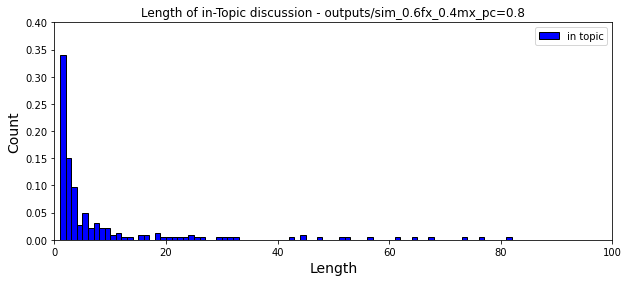

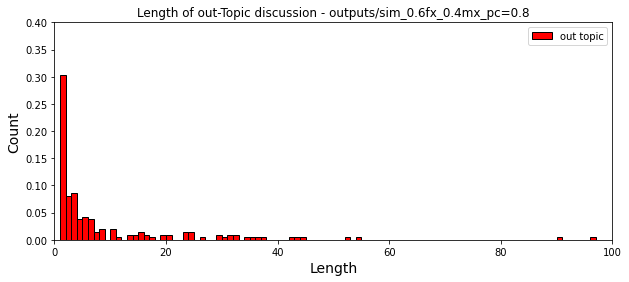

In [74]:
in_topic = []
out_topic = []

for i in range(1, simulation_times + 1):
    curr_path = f"{folder_path}/{i}.csv"
    # print(x.to_string())
        
    df = pd.read_csv(curr_path)
    
    in_, out_ = split_topics(df["Topic Divergence"].astype(int))
    in_topic += in_
    out_topic += out_
    # print(out_topic)

plot_one_topic_histogram(in_topic, "in", folder_path, normalised = True)
plot_one_topic_histogram(out_topic, "out", folder_path, normalised = True)

In [ ]:
# plot overlapping histograms

# in_topic = []
# out_topic = []

# for i in range(1, simulation_times + 1):
#     curr_path = f"{folder_path}/{i}.csv"
#     # print(x.to_string())
    
#     df = pd.read_csv(curr_path)
#     # print(x.to_string())
#     in_, out_ = split_topics(df["Topic Divergence"].astype(int))
#     in_topic += in_
#     out_topic += out_

# plot_topic_histogram(in_topic, out_topic, method = "Old", normalised = False)
# plot_topic_histogram(in_topic, out_topic, method = "Old", normalised = True)

In [ ]:
iterations = 200
repeat_report = netlogo.repeat_report(["length last [board_history] of one-of boards"], iterations)

for window_size in [5,10,25]:
    roll = repeat_report.rolling(window=window_size).mean()

    plt.figure(figsize=(16, 5))
    plt.plot(repeat_report, 'b-', label='burst length')
    plt.plot(roll, 'r-', label='moving average')

    plt.title(f"Burst Lengths and Moving Average ({window_size})")
    plt.ylabel('Burst Length')
    plt.xlabel('Ticks')
    plt.legend(loc='upper left')
    plt.show()

def graph_burst_length(burst_length_data):
    """
    burst_length_data : Series
        lengths of bursts by tick
    """
    roll = burst_length_data.rolling(window=5).mean()

    plt.figure(figsize=(16, 5))
    plt.plot(burst_length_data, 'b-', label='burst length')
    plt.plot(roll, 'r-', label='moving average')

    plt.title("Burst Lengths and Moving Average (5 ticks)")
    plt.ylabel('Burst Length')
    plt.xlabel('Ticks')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
netlogo.command("set female_prob_exploit 0.5")
netlogo.command("set male_prob_exploit 0.3")

iterations = 50
report = netlogo.repeat_report(\
    ["[male_participation] of one-of boards", "[female_participation] of one-of boards"],
    iterations)

fig, ax = plt.subplots()
ax.set_xlabel("Tick")
ax.set_ylabel("Gender Participation")
plt.title("Gender Participation / Tick")
sns.lineplot(data=report.iloc[:])

# report.iloc[0] get by tick

### Graphs

In [ ]:
def plot_1d_arr(arr, ylabel, aspect=70):
    df = pd.DataFrame(arr)

    fig, ax = plt.subplots()
    ax.set_aspect(aspect)
    ax.set_xlabel("Tick")
    ax.set_ylabel(ylabel)
    fig.patch.set_facecolor('white')
    plt.title(f"{ylabel} / Tick")

    sns.lineplot(data=df, x=range(len(arr)), y=df[0])
    # print(df.describe())

## Helper

### Manage Simulation

In [ ]:
def show_sim_stats():
    """prints graph pertaining to the ran simulation"""
    iterations = 50
    male_part, female_part, topic_divergence, true_ratio, burst_lengths = netlogo.repeat_report(\
        ["[male_participation] of one-of boards", "[female_participation] of one-of boards", "compat_ratio", "[ratio] of one-of boards", "length last [board_history] of one-of boards"],\
    iterations)

    plot_1d_arr(female_part, ylabel="F Participation")
    plot_1d_arr(male_part, ylabel="M Participation")
    plot_1d_arr(netlogo.report("burst-length-report"), ylabel="Burst Length", aspect=20)
    graph_burst_length(burst_lengths)

### Setup Scenarios

In [78]:
# Scenario:sub-scenario : [females, males, female_prob_exploit, male_prob_exploit, posting_chance]
new_scenarios = {
    # Working class
    1.1 : [1, 1, 0.45, 0.25, 0.65],
    1.2 : [2, 1, 0.45, 0.25, 0.65],
    1.3 : [1, 1, 0.45, 0.25, 0.8],
    1.4 : [2, 1, 0.45, 0.25, 0.8],
    
    # Upper class
    2.1 : [1, 1, 0.85, 0.8, 0.65],
    2.2 : [2, 1, 0.85, 0.8, 0.65],
    2.3 : [1, 1, 0.85, 0.8, 0.8],
    2.4 : [2, 1, 0.85, 0.8, 0.8],
    
    # Middle class
    3.1 : [1, 1, 0.6, 0.5, 0.65],
    3.2 : [2, 1, 0.6, 0.5, 0.65],
    3.3 : [1, 1, 0.6, 0.5, 0.8],
    3.4 : [2, 1, 0.6, 0.5, 0.8],
}



Starting Sim {code}


iter 1
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
iter 2
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
iter 3
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
iter 4
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RAT

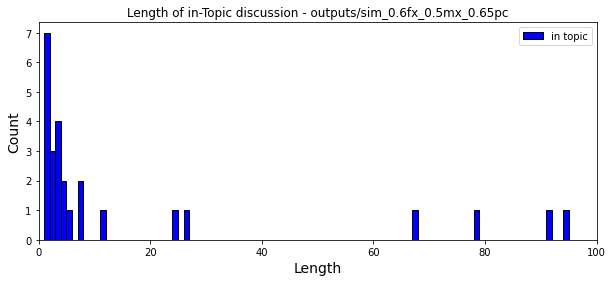

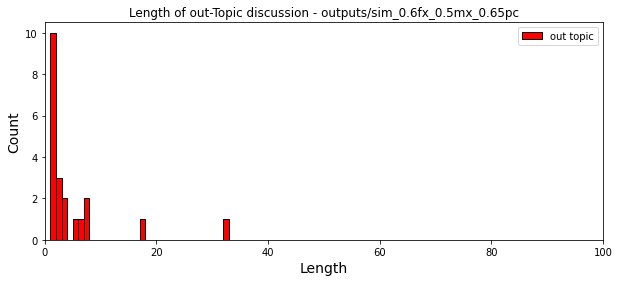

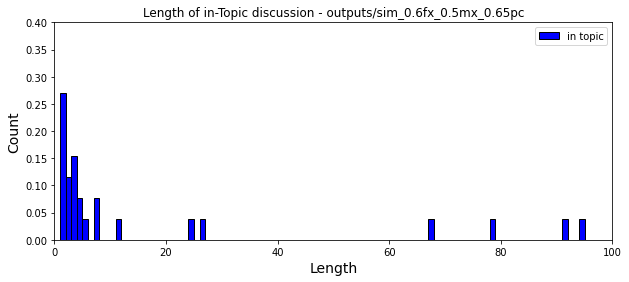

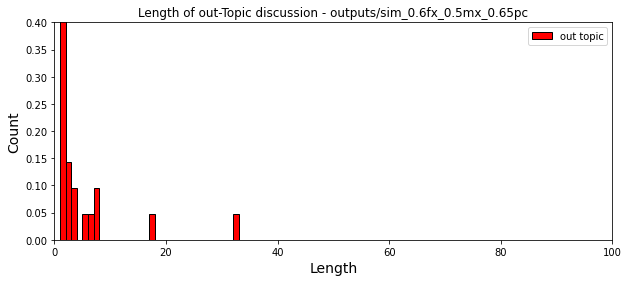

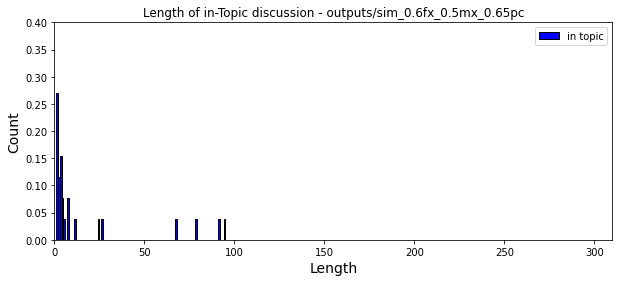

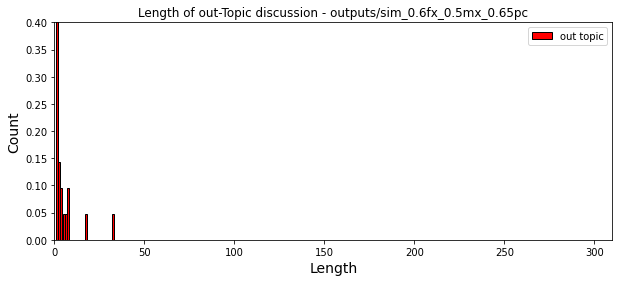



Starting Sim {code}


iter 1
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
iter 2
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
iter 3
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
iter 4
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RAT

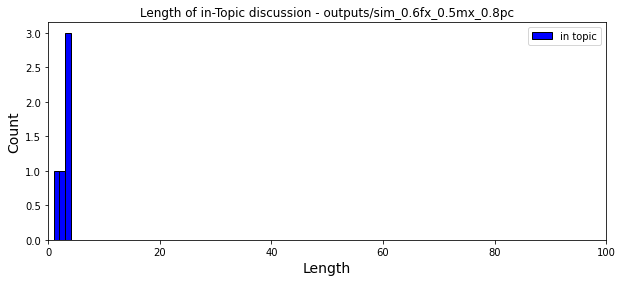

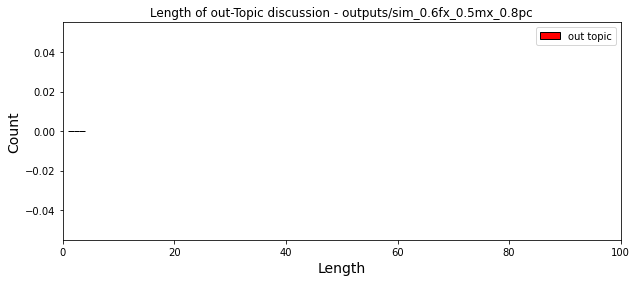

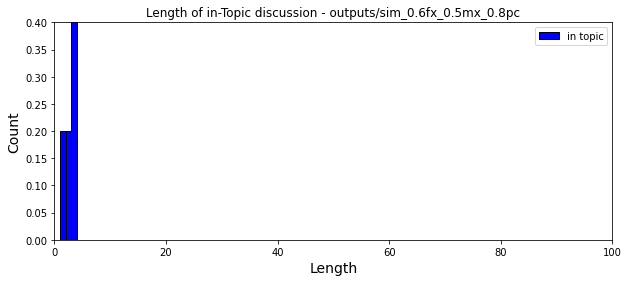

/home/paulo/Desktop/TFC/github_repo/TFC-DEISI258-Modelamento-multi-agente-de-intera-es-em-grupos-sociais/tfc_venv/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


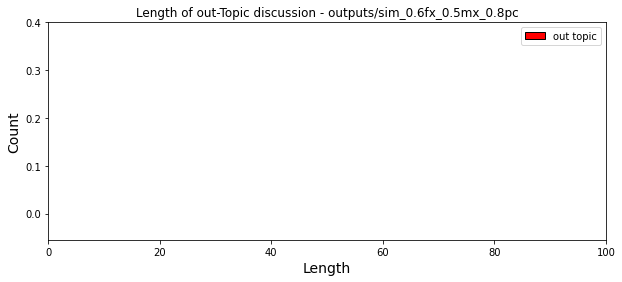

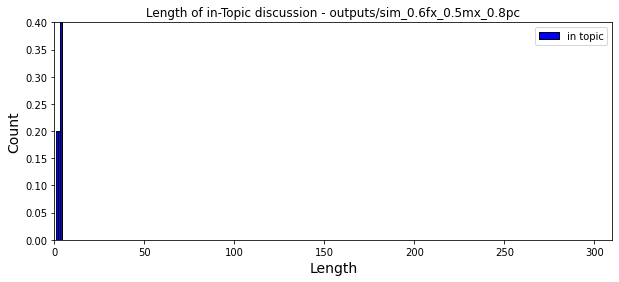

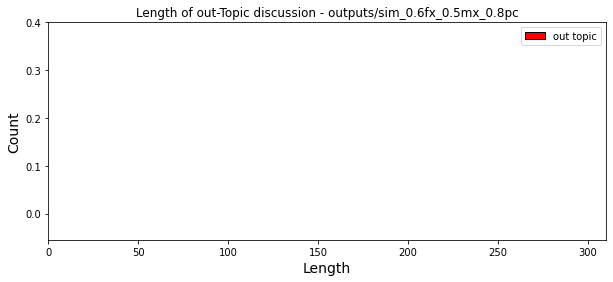

In [86]:
for code, [f, m, fx, mx, pc] in new_scenarios.items():
    print("\n\nStarting Sim {code}\n\n")
    # sim options
    simulation_times = 50
    iterations = 300

    reported_columns = [
        "compat_ratio", 
        "[ratio] of one-of boards", 
        "length last [board_history] of one-of boards"
    ]

    netlogo.command(f"set female_prob_exploit {fx}")
    netlogo.command(f"set male_prob_exploit {mx}")
    netlogo.command(f"set posting_chance {pc}")
    netlogo.command("set number_of_agents 15")
    netlogo.command(f'set Method "Attention Norm"')

    # create path if it doesnt exist yet
    folder_path = f"outputs/sim_{fx}fx_{mx}mx_{pc}pc"
    if not os.path.exists(folder_path): os.makedirs(folder_path) 

    in_topic = []
    out_topic = []

    for i in range(1, simulation_times + 1):
        print(f"iter {i}")

        netlogo.command("setup")
        curr_path = f"{folder_path}/{i}.csv"
        
        report = netlogo.repeat_report(reported_columns, iterations)
        report = fix_col_names(report)

        # write to file
        report.to_csv(curr_path)                
        
        in_, out_ = split_topics(report["Topic Divergence"].astype(int))
        in_topic += in_
        out_topic += out_

    plot_one_topic_histogram(in_topic, "in", folder_path, normalised = False)
    plot_one_topic_histogram(out_topic, "out", folder_path, normalised = False)
    plot_one_topic_histogram(in_topic, "in", folder_path, normalised = True)
    plot_one_topic_histogram(out_topic, "out", folder_path, normalised = True)
    plot_one_topic_histogram(in_topic, "in", folder_path, normalised = True, xlim = 310)
    plot_one_topic_histogram(out_topic, "out", folder_path, normalised = True, xlim = 310)

## Run Simulation (Normal Divergence)

### Topic Divergence (-1 / 1)

In [ ]:
def plot_topic(indexes, data, in_out, scenario):

    if in_out not in ["in", "out", "polarised"]: 
        print("invalid in / out")
        return
    
    topic_print = 'In-Topic' if in_out == 'in' else 'Out-of-Topic' if in_out == 'out' else 'Polarised'
    
    plt.ylabel("Count")

    plt.xlabel(f"{topic_print} Length")

    plt.title(f"{scenario} Lengths of {topic_print} Discussions")
    plt.bar(indexes, list(data.values()))
    plt.xticks(indexes, list(data.keys()))

    plt.savefig(f"plots/{scenario}_{in_out}_topic.png")
    plt.show()

In [ ]:
# concat all in/out of topic lengths
def read_in_topic(scenario, divergency):

    if divergency:
        file_path = f"outputs/{scenario}_compat_ratios.csv"
    else:
        file_path = f"outputs/{scenario}_topic_data.csv"

    in_topic = []
    out_topic = []

    with open(file_path) as fp:
        
        for l in fp.readlines():
            # -1 -> 0 | 1 -> 1
            # print(l.split())
            # lst = [e for e in l if e.isalnum() or e == "-1"]
            lst = [e for e in l.split(",")]
            print(f"{lst=}")
            topics = split_topics(lst)
            out_topic += topics[0]
            in_topic += topics[1]

    return out_topic, in_topic

def run_scenario(method, females, males, f_exploit, m_exploit, scenario, iterations = 5):
    file_path = f"outputs/{scenario}_compat_ratios.csv"
    if os.path.exists(file_path): os.remove(file_path) # reset file

    netlogo.command(f'set Method "Attention Norm - {method}"')
    netlogo.command(f'set females {females}')
    netlogo.command(f'set males {males}')
    netlogo.command(f'set female_prob_exploit {f_exploit}')
    netlogo.command(f'set male_prob_exploit {m_exploit}')

    for _ in range(iterations):
        netlogo.command("setup")
        netlogo.command("repeat 50 [go]")

        messages = netlogo.report("compat-ratio-report").astype(int)
        with open(file_path, "a+") as fp:
            # fp.write(f"{[x for x in messages]}")
            fp.write(','.join(str(x) for x in messages))
            fp.write("\n")

    # return the length counts for in/out topic
    out_topic, in_topic = read_in_topic(scenario, divergency = True)

    return  dict(sorted(Counter(out_topic).items())), dict(sorted(Counter(in_topic).items())), 


def show_topic_divergence(scenario):
    topic = [[],[]]

    messages = netlogo.report("get-in-topic").astype(int)
    # should_be = [[2, 1, 3], [3, 1, 1, 4]]

    with open(f"plots/{scenario}_in-topic-data.csv", "a+") as fp:
        fp.write(f"{list(messages)}")
        fp.write("\n")
    
    prev_compat = False

    for curr_compat in messages:
        
        if prev_compat == curr_compat: # continue last count
            topic[curr_compat][len(topic[curr_compat])-1] += 1
        else: # create new count
            topic[curr_compat].append(1)
        
        prev_compat = curr_compat

    # print(topic)

    sns.displot(topic[0], kde=True).set(title="Lengths of Out-of-Topic Discussions")
    x_ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    plt.xticks(x_ticks)

    sns.displot(topic[1], kde=True).set(title="Lengths of In-Topic Discussions")

### Run simulation

In [ ]:
out_topic, in_topic = read_in_topic(2.3)

out_topic = list(map(int,out_topic))
in_topic = list(map(int,in_topic))

out_topic_counter = dict(sorted(Counter(out_topic).items()))
in_topic_counter = dict(sorted(Counter(in_topic).items()))

ind = np.arange(len(out_topic_counter))
data = out_topic_counter

scenario_id = 2.3

indexes = np.arange(len(out_topic_counter))

plot_topic(indexes, out_topic_counter, "out",  scenario_id)
plot_topic(indexes, out_topic_counter, "out",  scenario_id)

indexes = np.arange(len(in_topic_counter))

plot_topic(indexes, in_topic_counter, "in",  scenario_id)
plot_topic(indexes, in_topic_counter, "in",  scenario_id)

## Run Simulation Polarisation

### Topic Divergence (with Polarisation -1 / 0 / 1)

In [ ]:
def plot_from_files_polarised(scenario):
    # return the length counts for in/out topic
    out_topic, polarised_topic, in_topic = read_in_topic_polarised(scenario)
        
    out_topic_counter = dict(sorted(Counter(out_topic).items()))
    indexes = np.arange(len(out_topic_counter))
    plot_topic(indexes, out_topic_counter, "out",  scenario)
    
    in_topic_counter = dict(sorted(Counter(in_topic).items()))
    indexes = np.arange(len(in_topic_counter))
    plot_topic(indexes, in_topic_counter, "in",  scenario)

    polarised_topic_counter = dict(sorted(Counter(polarised_topic).items()))    
    indexes = np.arange(len(polarised_topic_counter))
    plot_topic(indexes, polarised_topic_counter, "polarised",  scenario)

    common_params = dict(bins=100, range=(1, 200), density = True)

    ax = plt.hist((out_topic, in_topic, polarised_topic), **common_params)
    plt.legend(["out of topic", "in topic", "polarised discussion"])
    plt.title("Type of Discussion Length")
    plt.ylabel("Prevalence")
    plt.xlabel("Length of Discussion")

In [ ]:
# compat-ratio-report-with-polarisation
def split_topics_polarised(messages):
    topic = [[],[],[]]
    # convert to int
    messages = [int(e) for e in messages]
    
    prev_compat = -1

    topic_indexes = {
        -1 : 0,
        0 : 1,
        1 : 2,
    }

    for curr_compat in messages:
        index = topic_indexes[curr_compat]
        
        if prev_compat == curr_compat: # continue last count    
            topic[index][len(topic[index]) - 1] += 1
        else: # create new count
            topic[index].append(1)
        
        prev_compat = curr_compat
    
    # print(topic)
    return topic

# concat all in/out of topic lengths
def read_in_topic_polarised(scenario):
    file_path = f"outputs/{scenario}_compat_ratios_polarisation.csv"

    in_topic = []
    out_topic = []
    polarised_topic = []

    with open(file_path) as fp:
        
        for l in fp.readlines():
            # -1 -> 0 | 1 -> 1
            # print(l.split())
            # lst = [e for e in l if e.isalnum() or e == "-1"]
            lst = [e for e in l.strip("\n").split(",")]
            # print(f"{lst=}")
            topics = split_topics_polarised(lst)
            out_topic += topics[0]
            polarised_topic += topics[1]
            in_topic += topics[2]

    return out_topic, polarised_topic, in_topic

def run_scenario_polarised(method, females, males, f_exploit, m_exploit, scenario, iterations = 1):
    file_path = f"outputs/{scenario}_compat_ratios_polarisation.csv"
    if os.path.exists(file_path): os.remove(file_path) # reset file

    netlogo.command(f'set Method "Attention Norm - {method}"')
    netlogo.command("set number_of_agents 15")
    netlogo.command(f'set females {females}')
    netlogo.command(f'set males {males}')
    netlogo.command(f'set female_prob_exploit {f_exploit}')
    netlogo.command(f'set male_prob_exploit {m_exploit}')

    for _ in range(iterations):    
        netlogo.command("setup")
        # netlogo.command("repeat 200 [go]")

        # messages = netlogo.report("compat-ratio-report-with-polarisation").astype(int)
        # messages = netlogo.repeat_report("compat_ratio", 200)
        report = netlogo.repeat_report(["[ratio] of one-of boards", "compat_ratio", "[male_participation] of one-of boards", "[female_participation] of one-of boards"], 20)
        report.to_csv(f"outputs/{scenario}_report.csv")
        # with open(file_path, "a+") as fp:
        #     fp.write(','.join(str(x) for x in messages))
        #     fp.write("\n")
    
    print(f"{scenario=} done")

In [ ]:
netlogo.command("setup")
# abou = netlogo.repeat_report("compat_ratio", 2)
# abou.to_csv("abou.csv")
# abou

### Run Simulation

In [ ]:
# for x in ["[ratio] of one-of boards", "compat_ratio", "divergencies_from_first_ku", "[male_participation] of one-of boards", "[female_participation] of one-of boards"]:
#     print(f"length of {x}")
netlogo.command("set number_of_agents 15")
netlogo.command("setup")

In [ ]:
report = netlogo.repeat_report(["[ratio] of one-of boards", "compat_ratio", "[male_participation] of one-of boards", "[female_participation] of one-of boards"], 20)
# report_div = netlogo.repeat_report(["divergencies_from_first_ku"], 2) divergencies first element is a 0 and not a []

In [ ]:
report.to_csv("aboubakar.csv")

In [ ]:
# scenario_ids = [1.2, 2.2, 2.3]
# for s in scenario_ids:
    # run_scenario_polarised(*scenarios[s], s)
run_scenario_polarised(*scenarios[1.1], 1.1, iterations=1)

In [ ]:
# messages = netlogo.report("compat-ratio-report").astype(int)
# file_path = f"outputs/1.1_compat_ratios.csv"
    
# with open(file_path, "a+") as fp:
#     fp.write(','.join(str(x) for x in messages))
#     fp.write("\n")

In [ ]:
reduced_scenarios = {
    # Working class
    1.1 : ["General", 1, 1, 0.45, 0.25],
    1.5 : ["Gendered", 1, 2, 0.45, 0.25],
    
    # Upper class    
    2.1 : ["General", 1, 1, 0.85, 0.8],
    2.5 : ["Gendered", 1, 2, 0.85, 0.8],
}

# run 3 scenarios
for scenario_id,v in reduced_scenarios.items():
    out_topic_counter, in_topic_counter = run_scenario(*v, scenario_id, 1)

    # sort
    out_topic_counter = dict(sorted(out_topic_counter.items()))
    in_topic_counter = dict(sorted(in_topic_counter.items()))

    indexes = np.arange(len(out_topic_counter))

    plot_topic(indexes, out_topic_counter, "out",  scenario_id)

    indexes = np.arange(len(in_topic_counter))

    plot_topic(indexes, in_topic_counter, "in",  scenario_id)

# TODO - NORMALIZED HISTOGRAM